In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from data_visualisation import *
from data_filtration import *
import matplotlib.image as mpimg
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df = df[df.UUID == 'b9407f30f5f8466eaff925556b57fe6d']

In [4]:
straight_line = df[df.SessId == 32]
standing_still = df[df.SessId == 31]

In [5]:
df = df[df.SessId != 32]
df = df[df.SessId != 31]

In [6]:
img = mpimg.imread('cropped_flat.png')

In [7]:
beacons = pd.DataFrame(
    {
        'Minor' : [
            "9619",
            "9617",
            "9609",
            "9616",
            "9618",
        ],
        'X' : [13.7,
               13.4,
               8.4,
               6.2,
               0.3,
              ],
        'Y' : [1.6,
               6.5,
               7.0,
               0.2,
               5.2,
              ],
    }
)

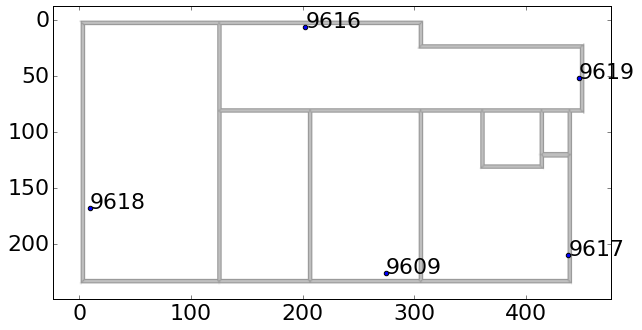

In [8]:
plt.figure(figsize=(10, 7))
plt.imshow(img)
plot_beacons(beacons, img)

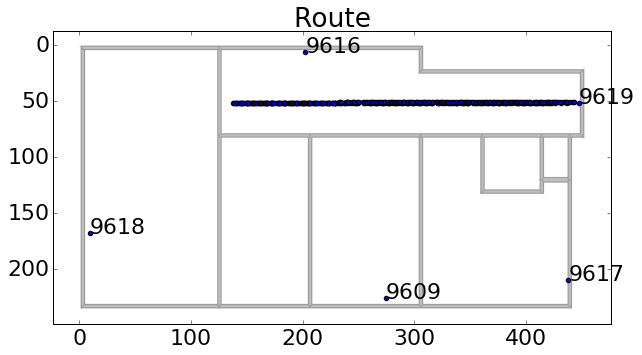

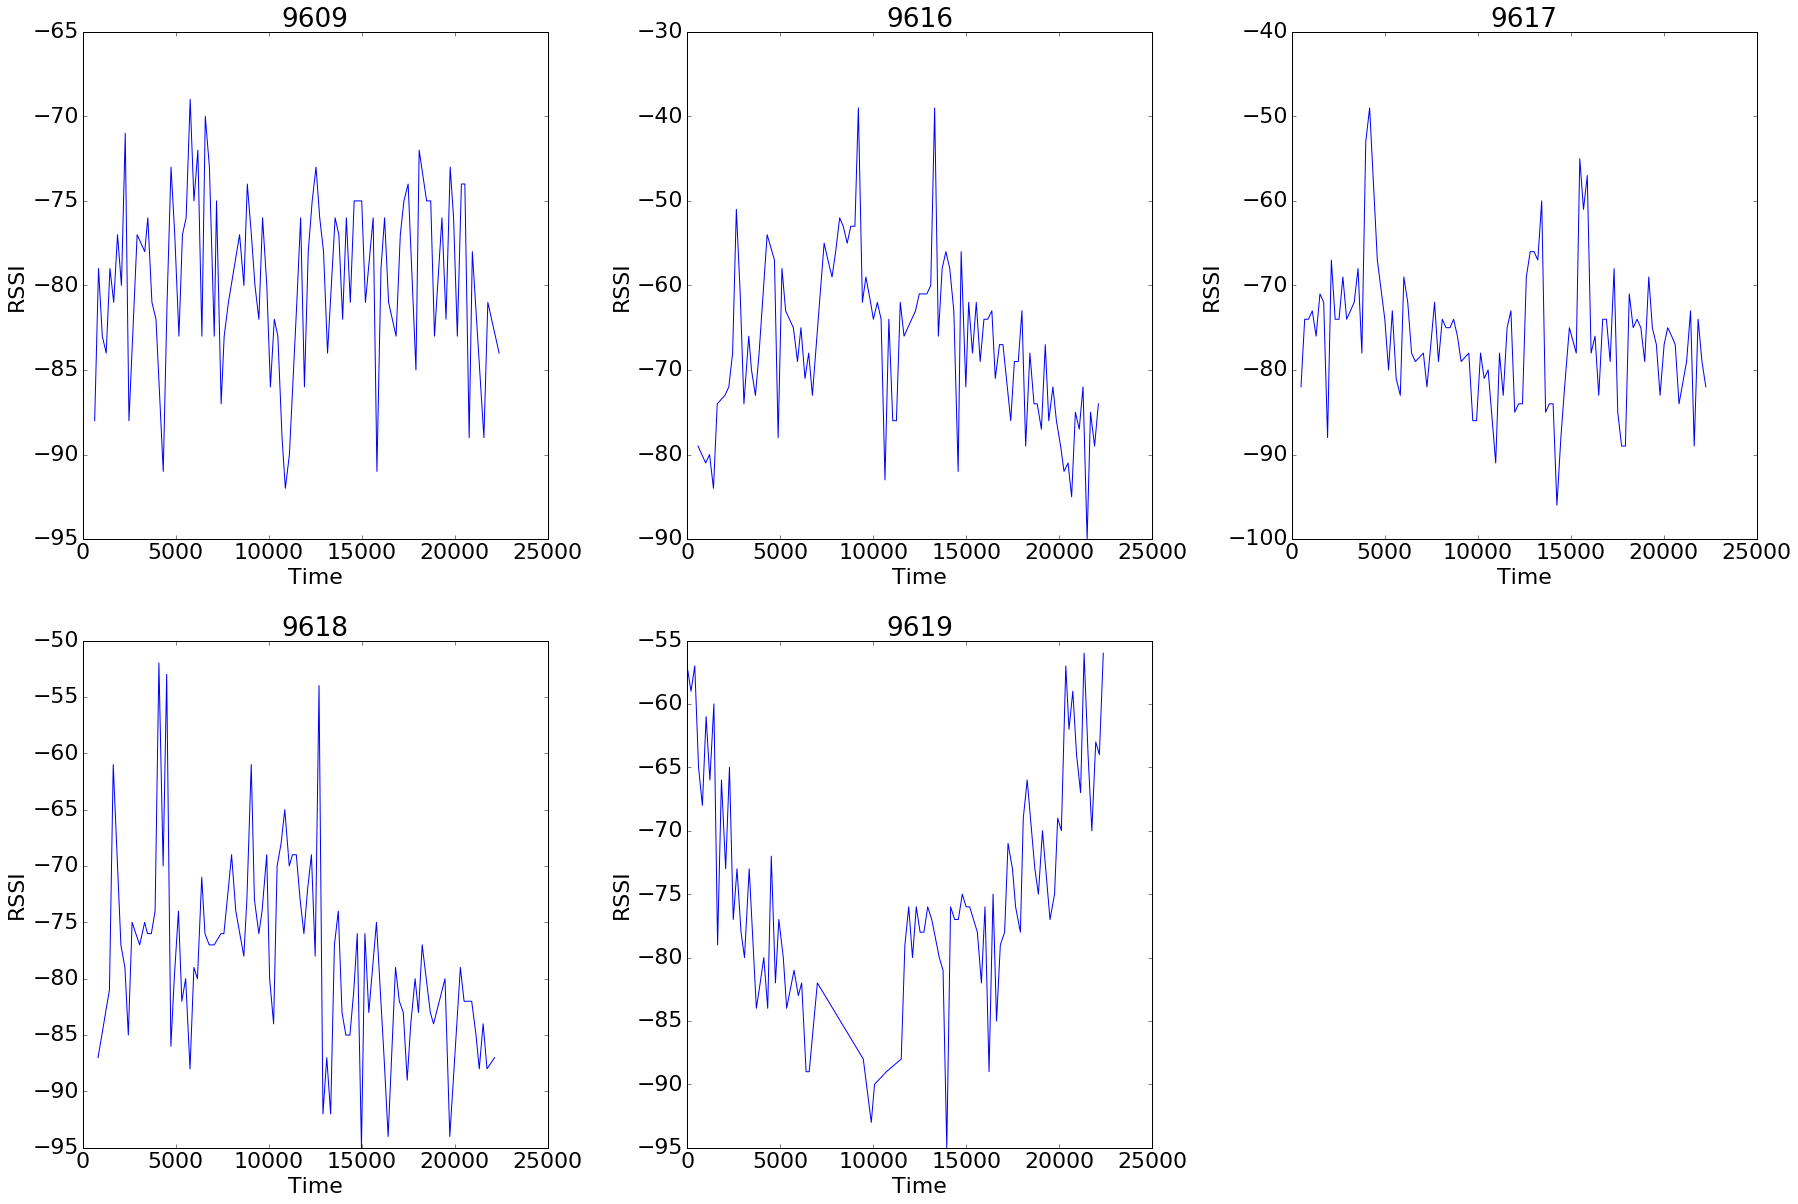

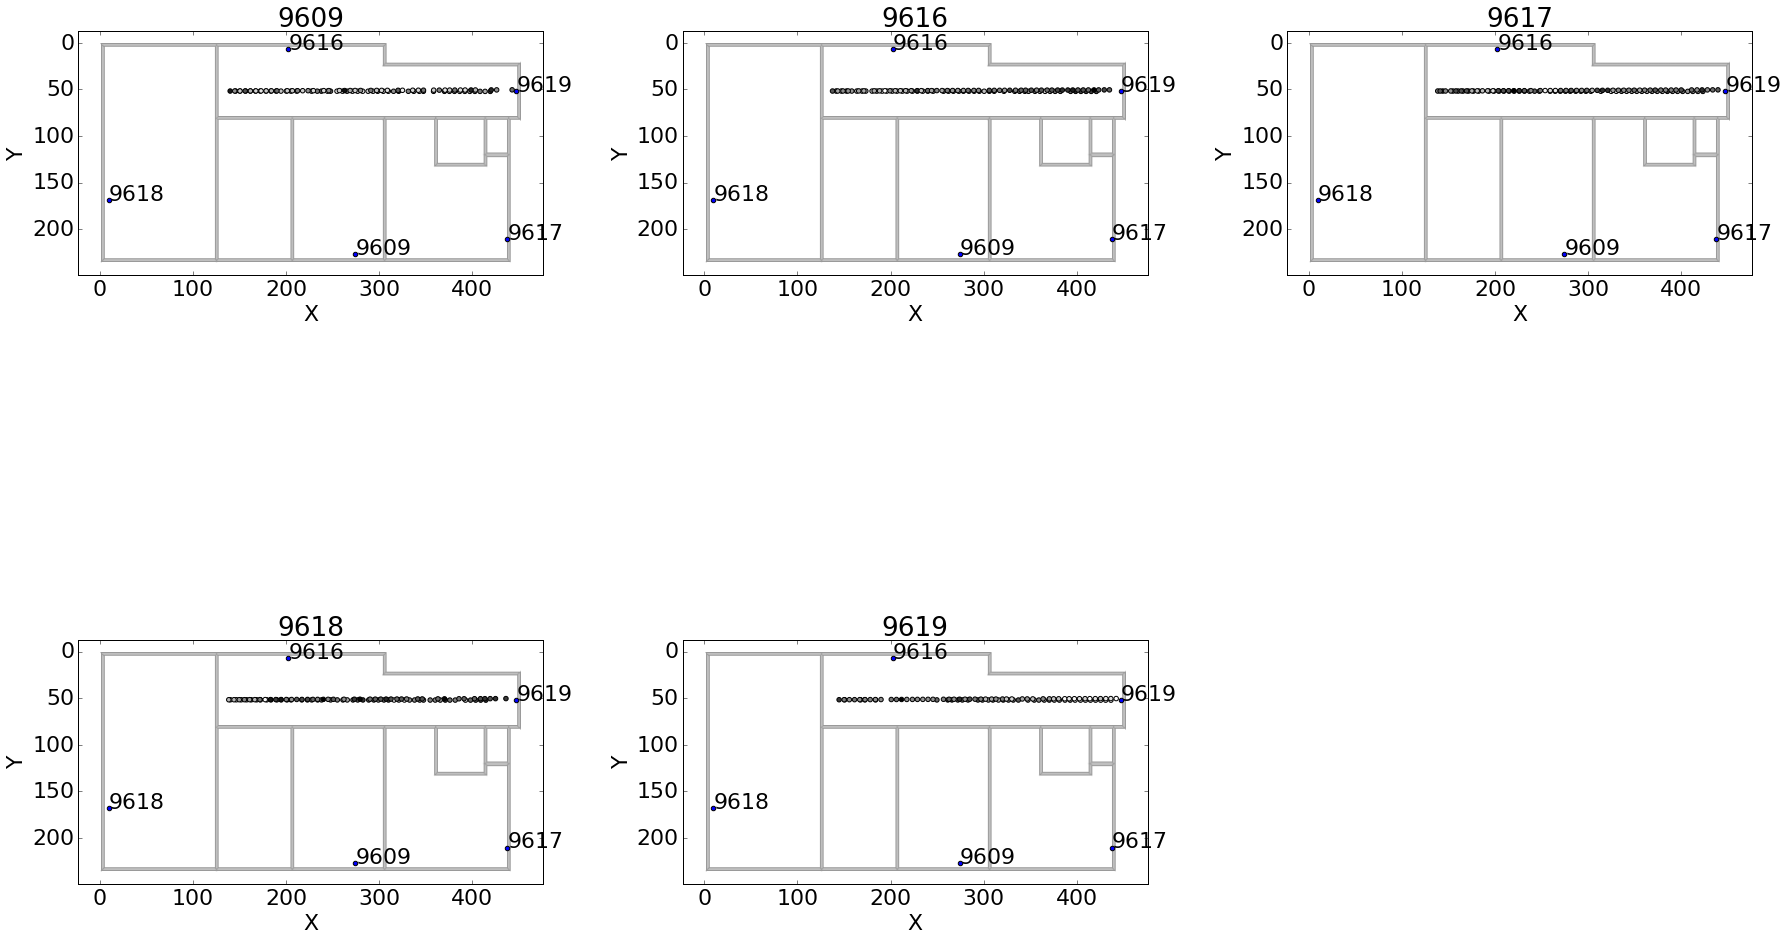

In [9]:
plot_session(straight_line, img, beacons=beacons)

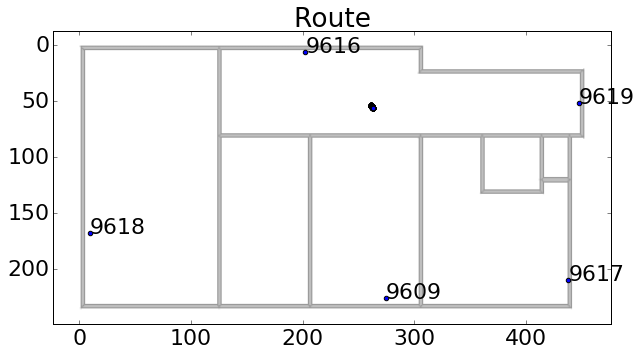

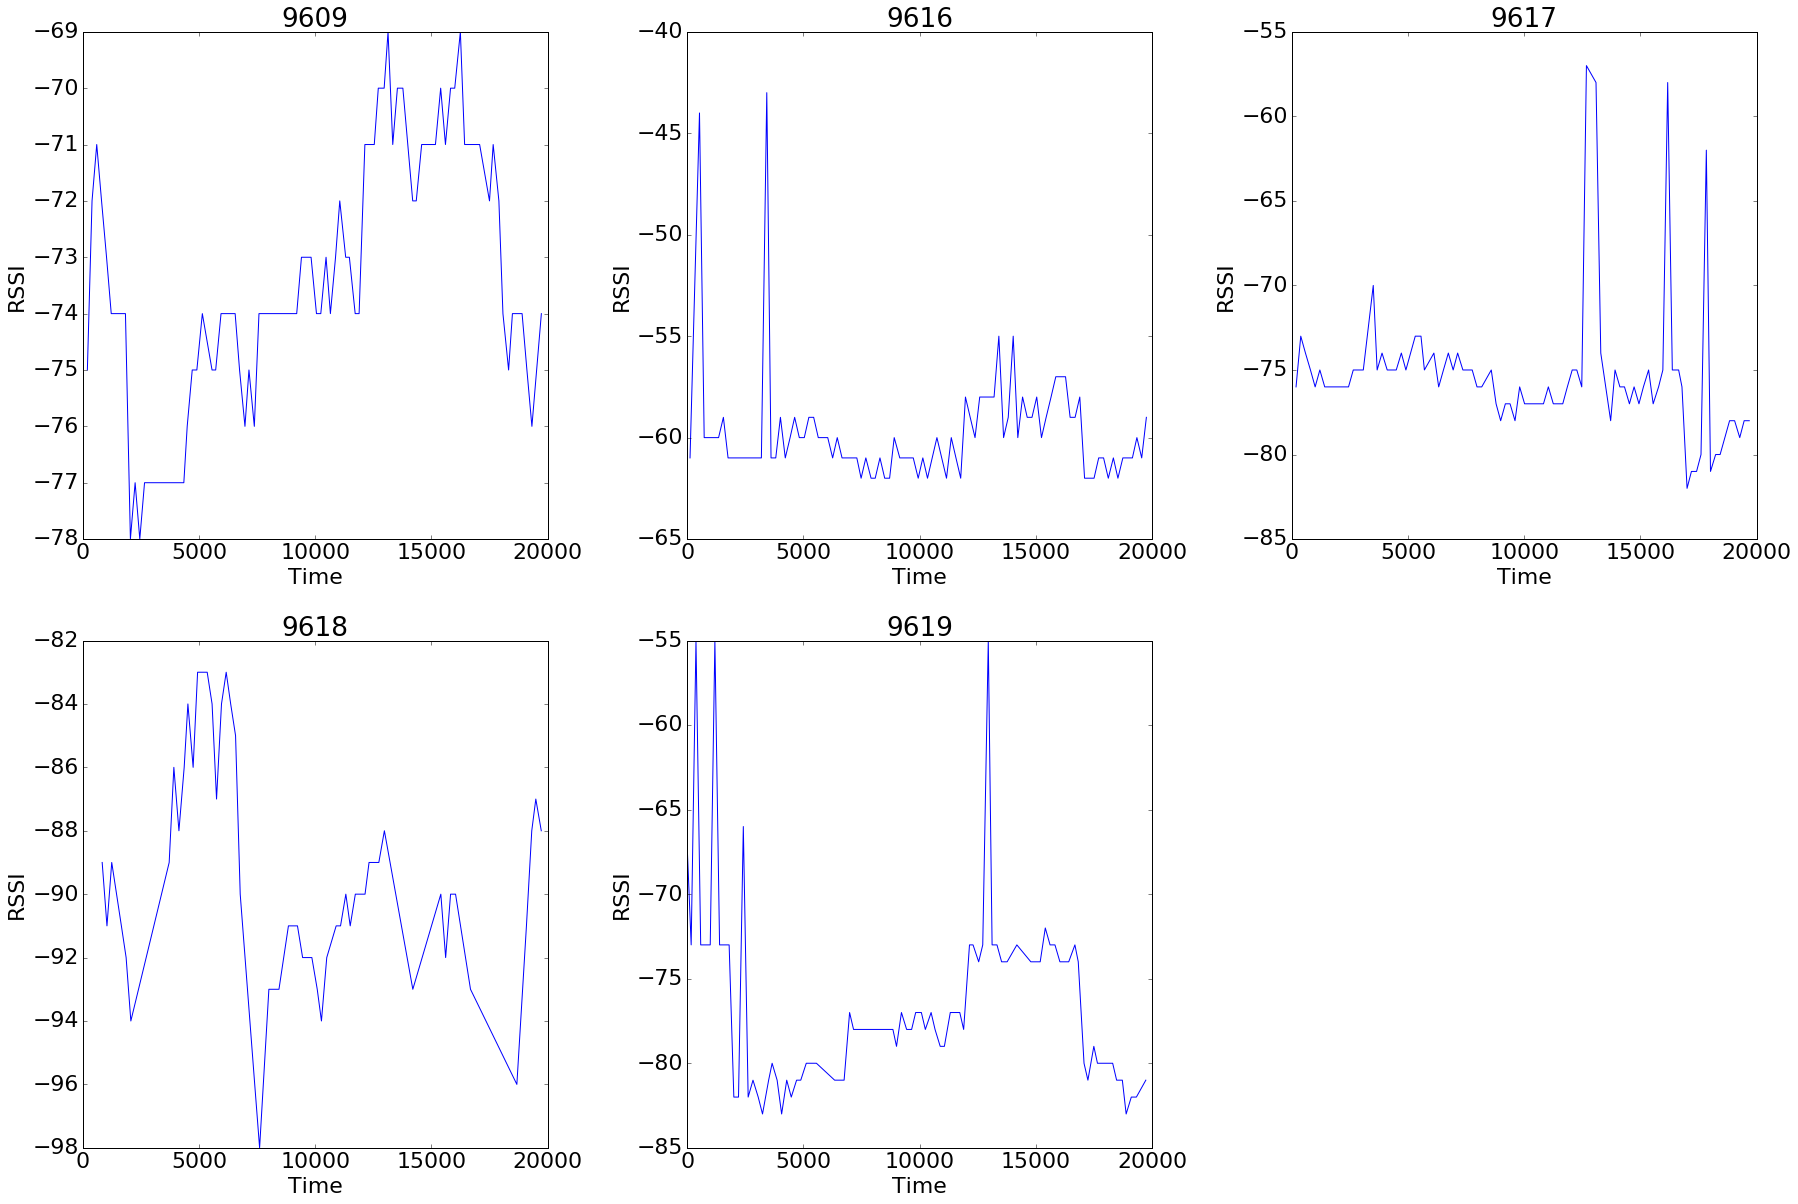

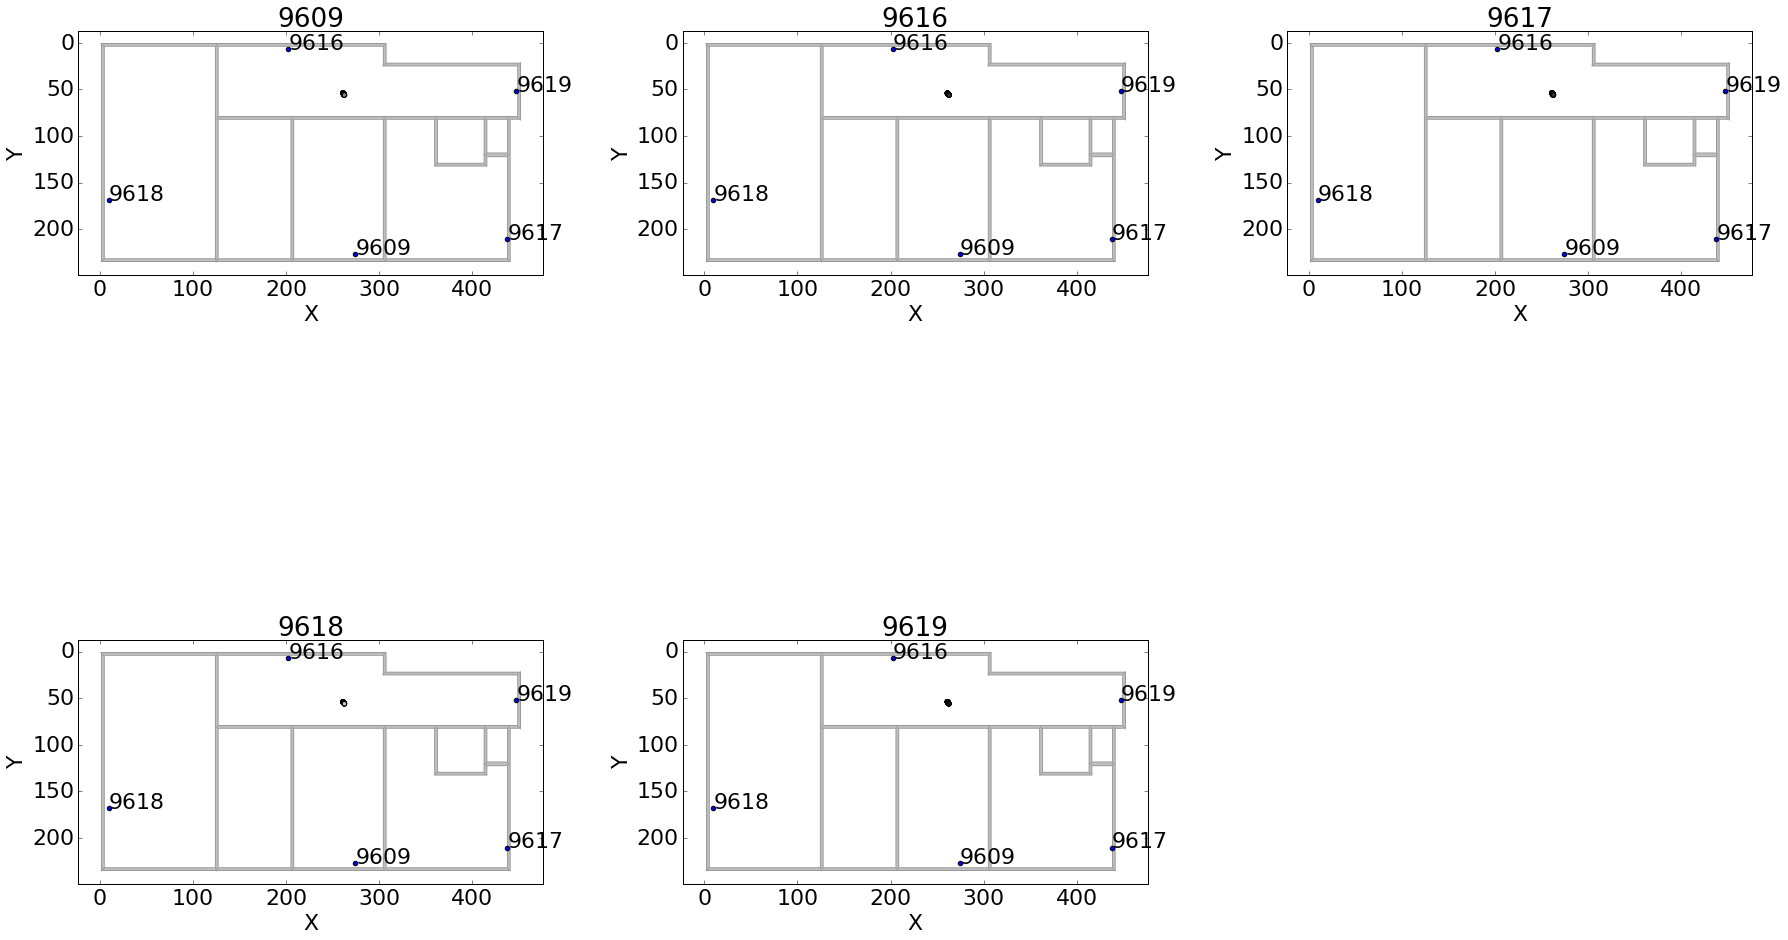

In [10]:
plot_session(standing_still, img, beacons=beacons)

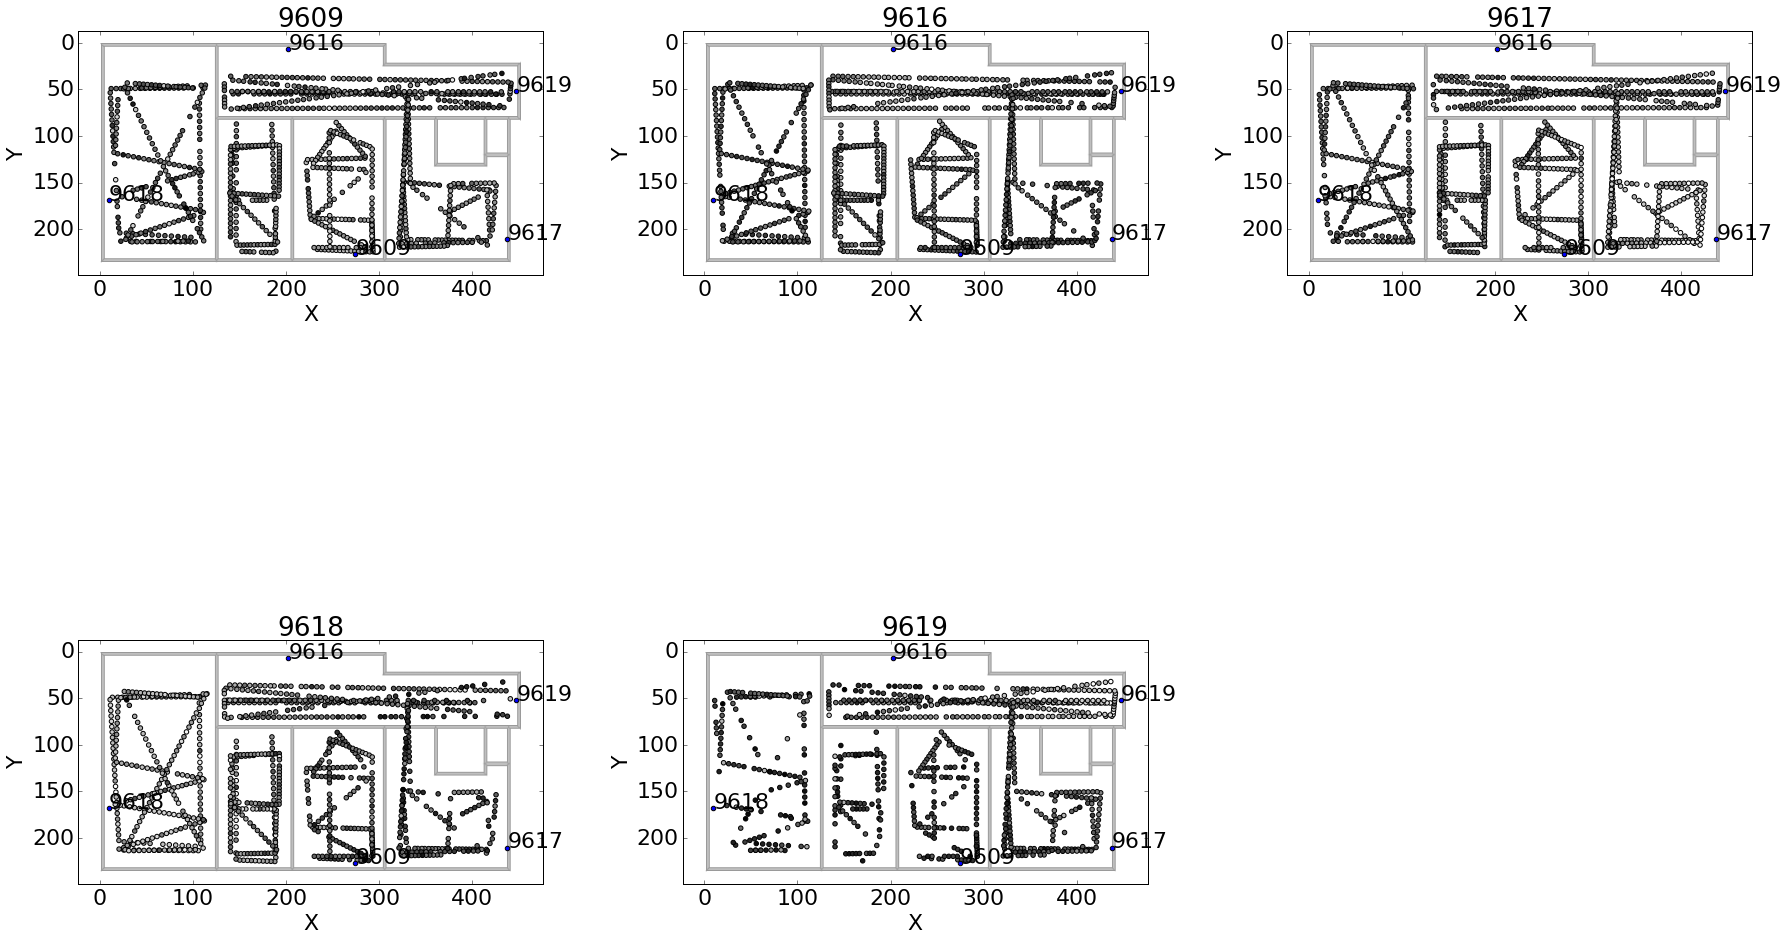

In [11]:
plot_rssi_map(df, img, beacons=beacons)

In [12]:
def print_per_minor_stats(df):
    minors = sorted(df.Minor.unique())
    for minor in minors:
        print("**Minor {}".format(minor))
        print(df[df.Minor == minor].RSSI.describe(),"\n\n")
    

In [13]:
print_per_minor_stats(standing_still)

**Minor 9609
count    86.000000
mean    -73.383721
std       2.223768
min     -78.000000
25%     -75.000000
50%     -74.000000
75%     -71.000000
max     -69.000000
Name: RSSI, dtype: float64 


**Minor 9616
count    93.000000
mean    -59.817204
std       2.843552
min     -62.000000
25%     -61.000000
50%     -61.000000
75%     -59.000000
max     -43.000000
Name: RSSI, dtype: float64 


**Minor 9617
count    89.000000
mean    -75.348315
std       4.117869
min     -82.000000
25%     -77.000000
50%     -76.000000
75%     -75.000000
max     -57.000000
Name: RSSI, dtype: float64 


**Minor 9618
count    56.000000
mean    -89.553571
std       3.546674
min     -98.000000
25%     -92.000000
50%     -90.000000
75%     -87.750000
max     -83.000000
Name: RSSI, dtype: float64 


**Minor 9619
count    87.000000
mean    -76.643678
std       5.523685
min     -83.000000
25%     -81.000000
50%     -78.000000
75%     -73.500000
max     -55.000000
Name: RSSI, dtype: float64 




In [14]:
print_per_minor_stats(straight_line)

**Minor 9609
count    90.000000
mean    -79.466667
std       5.162962
min     -92.000000
25%     -83.000000
50%     -79.000000
75%     -76.000000
max     -69.000000
Name: RSSI, dtype: float64 


**Minor 9616
count    99.000000
mean    -67.252525
std       9.602661
min     -90.000000
25%     -74.000000
50%     -67.000000
75%     -61.500000
max     -39.000000
Name: RSSI, dtype: float64 


**Minor 9617
count    100.000000
mean     -76.110000
std        7.930118
min      -96.000000
25%      -81.250000
50%      -76.000000
75%      -73.000000
max      -49.000000
Name: RSSI, dtype: float64 


**Minor 9618
count    92.000000
mean    -77.989130
std       8.334352
min     -95.000000
25%     -83.250000
50%     -78.000000
75%     -74.000000
max     -52.000000
Name: RSSI, dtype: float64 


**Minor 9619
count    86.000000
mean    -74.825581
std       9.140977
min     -95.000000
25%     -80.000000
50%     -76.000000
75%     -69.000000
max     -56.000000
Name: RSSI, dtype: float64 




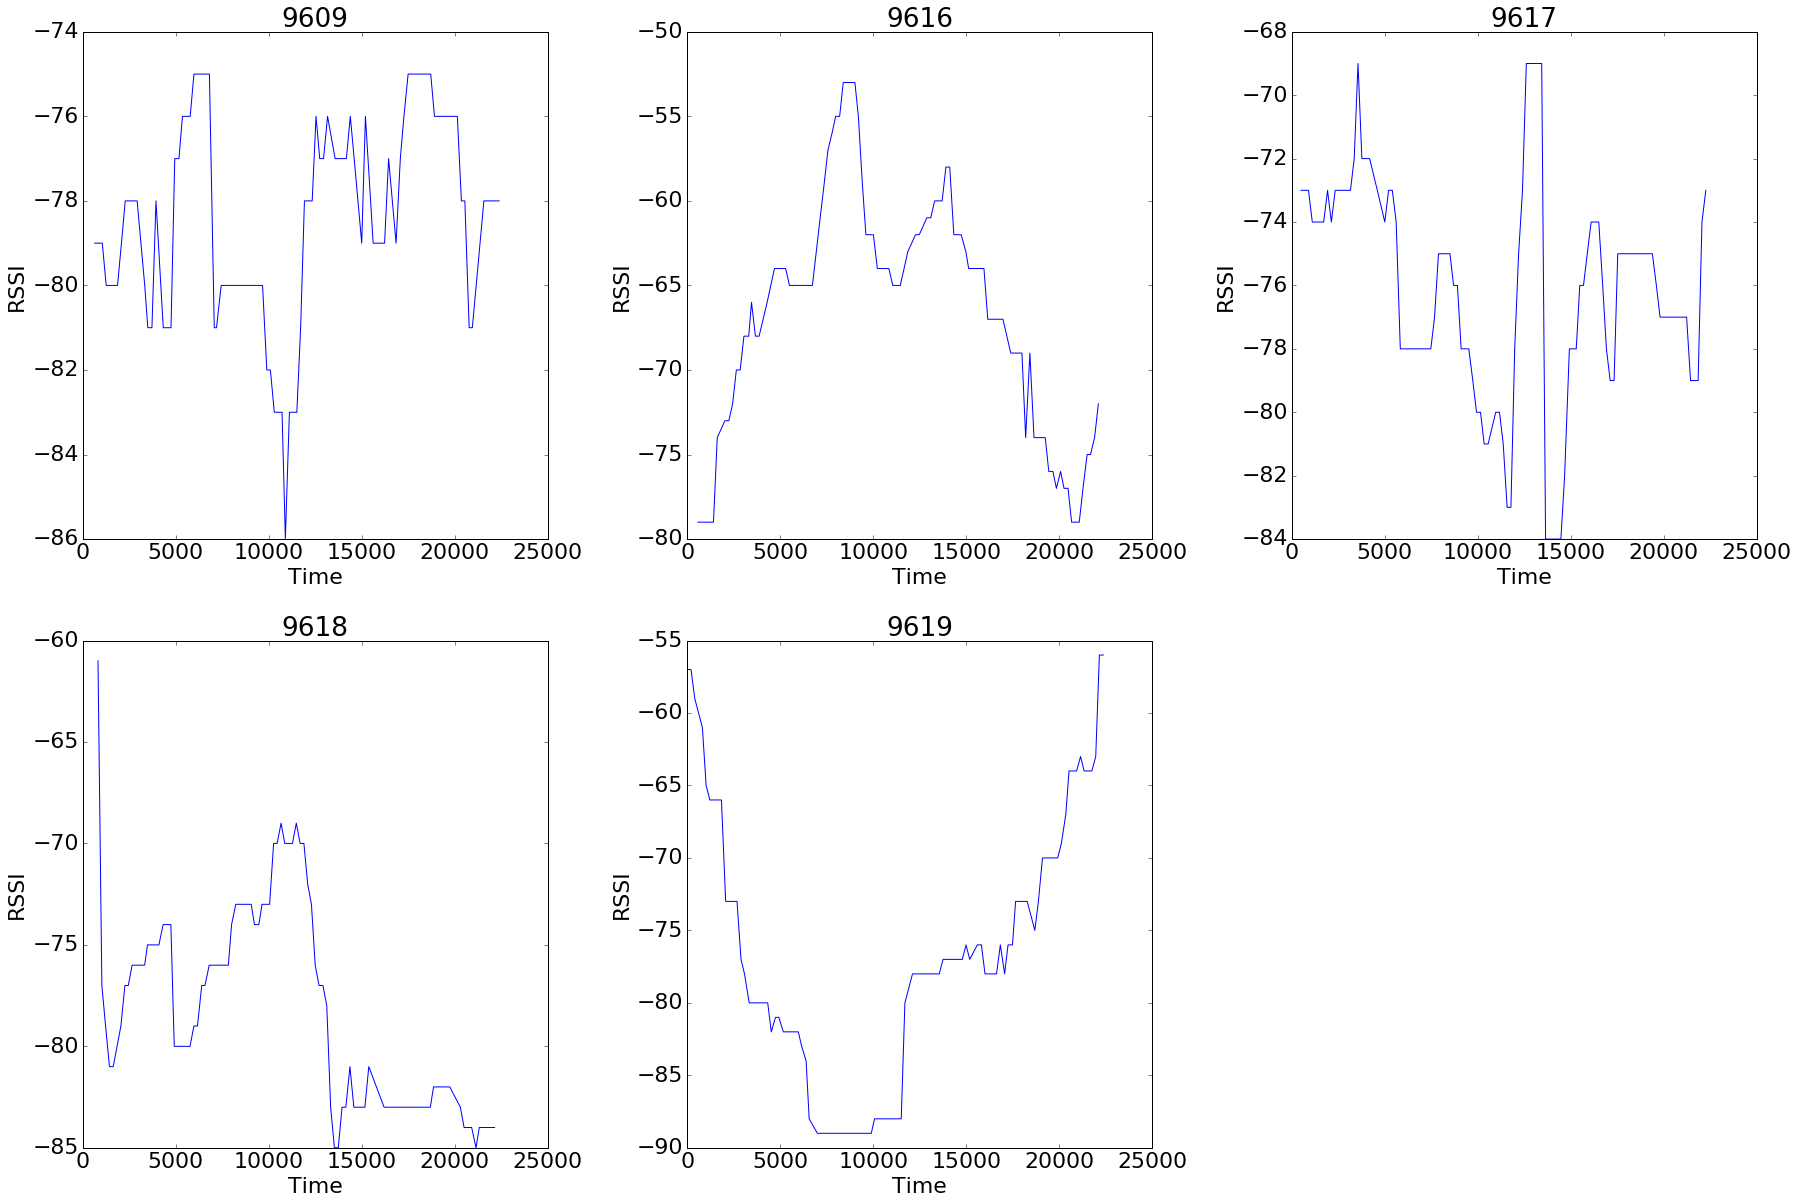

In [15]:
plot_rssi_data(straight_line, filter_func=create_rssi_median_filter(kernel=9))

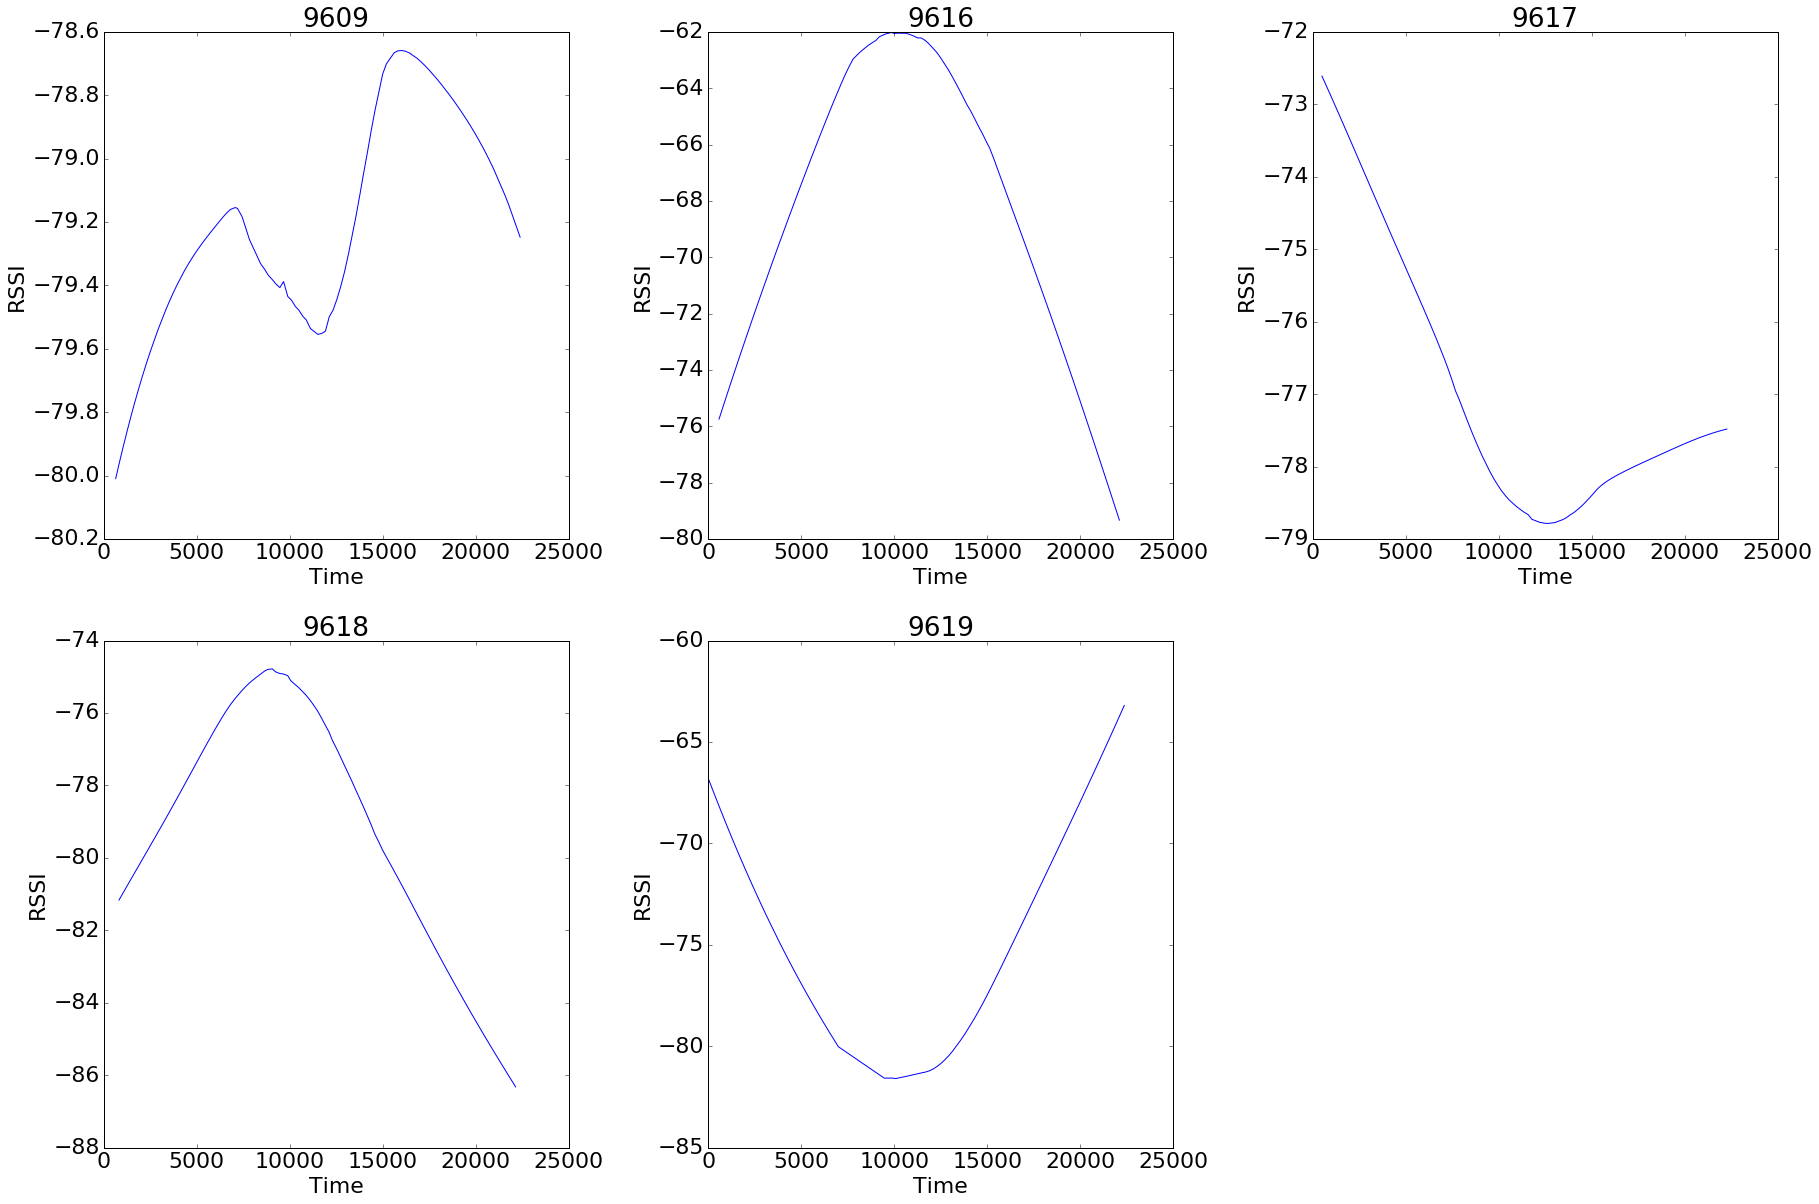

In [16]:
plot_rssi_data(straight_line, filter_func=rssi_lowess_filter)

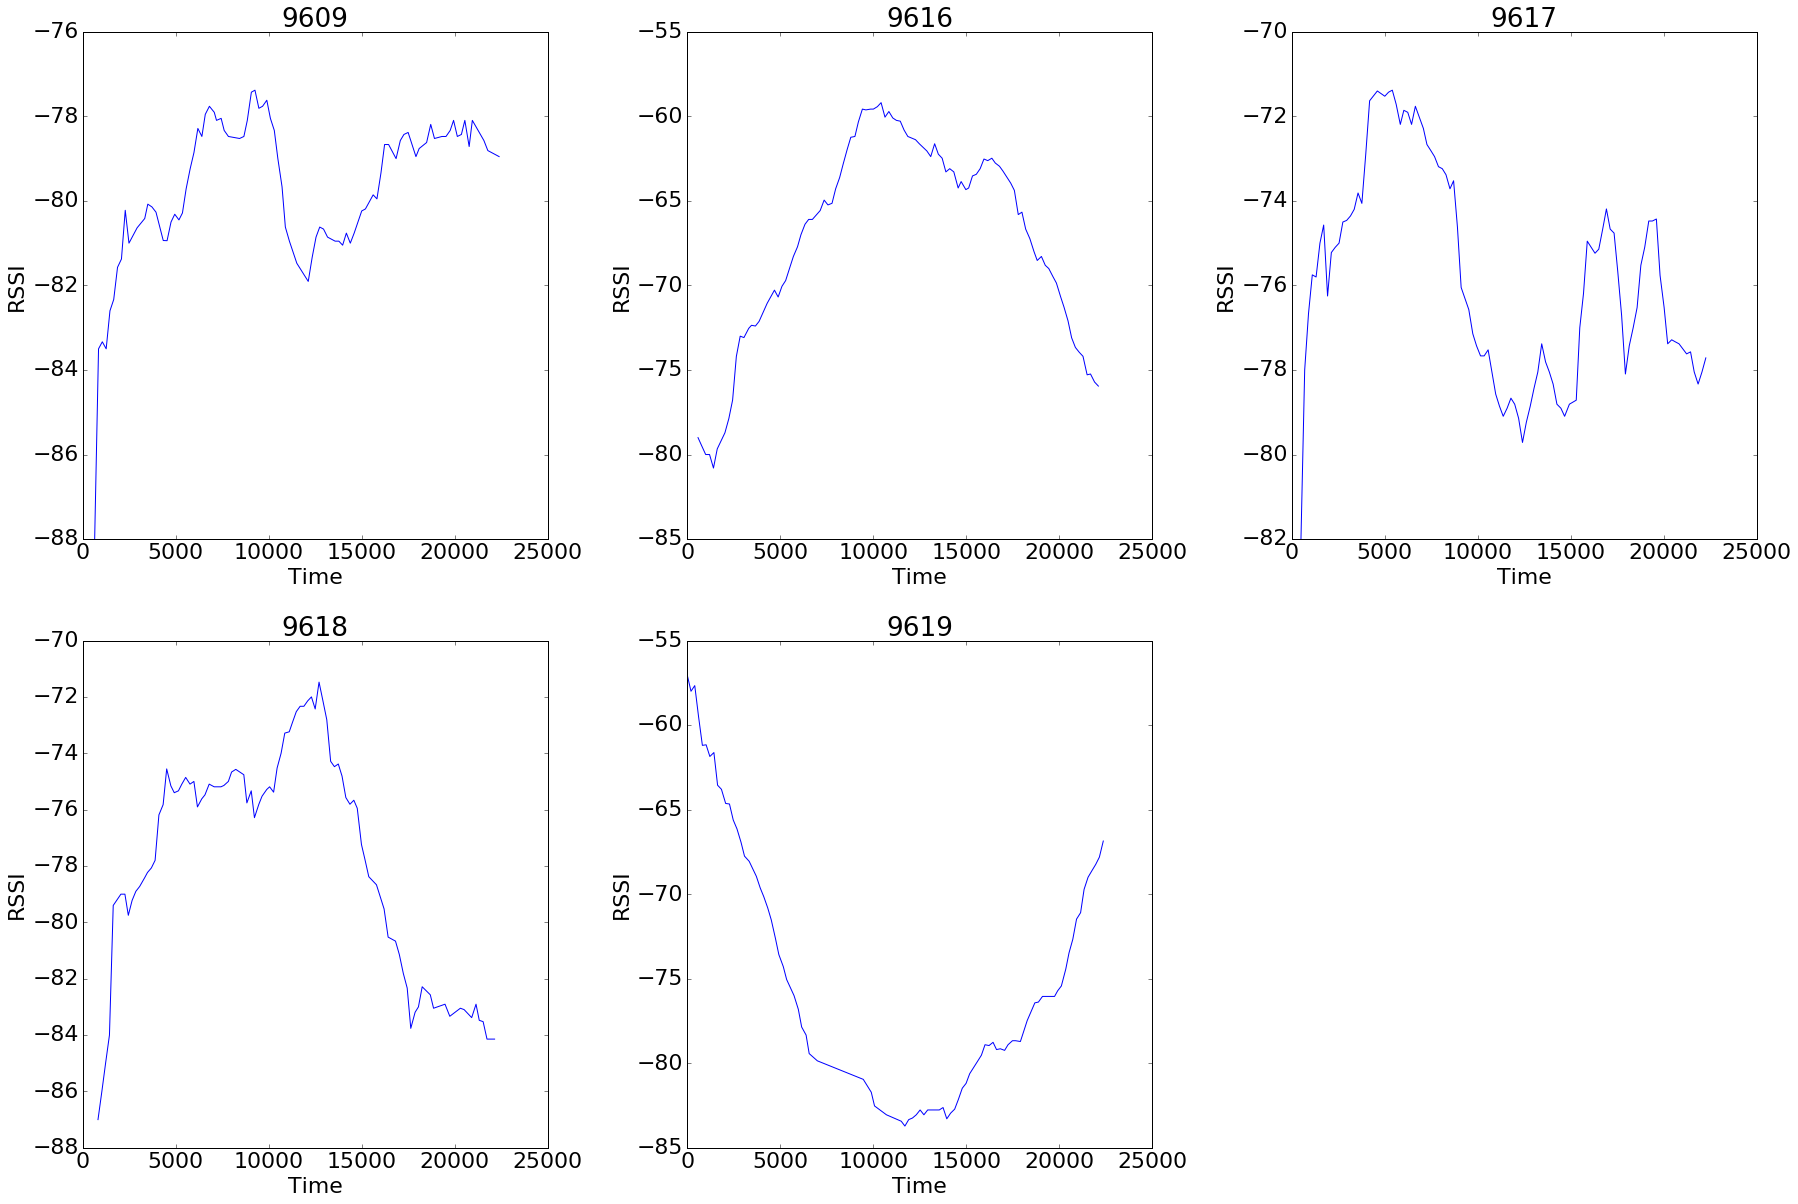

In [17]:
plot_rssi_data(straight_line, filter_func=create_rssi_avg_filter(21))

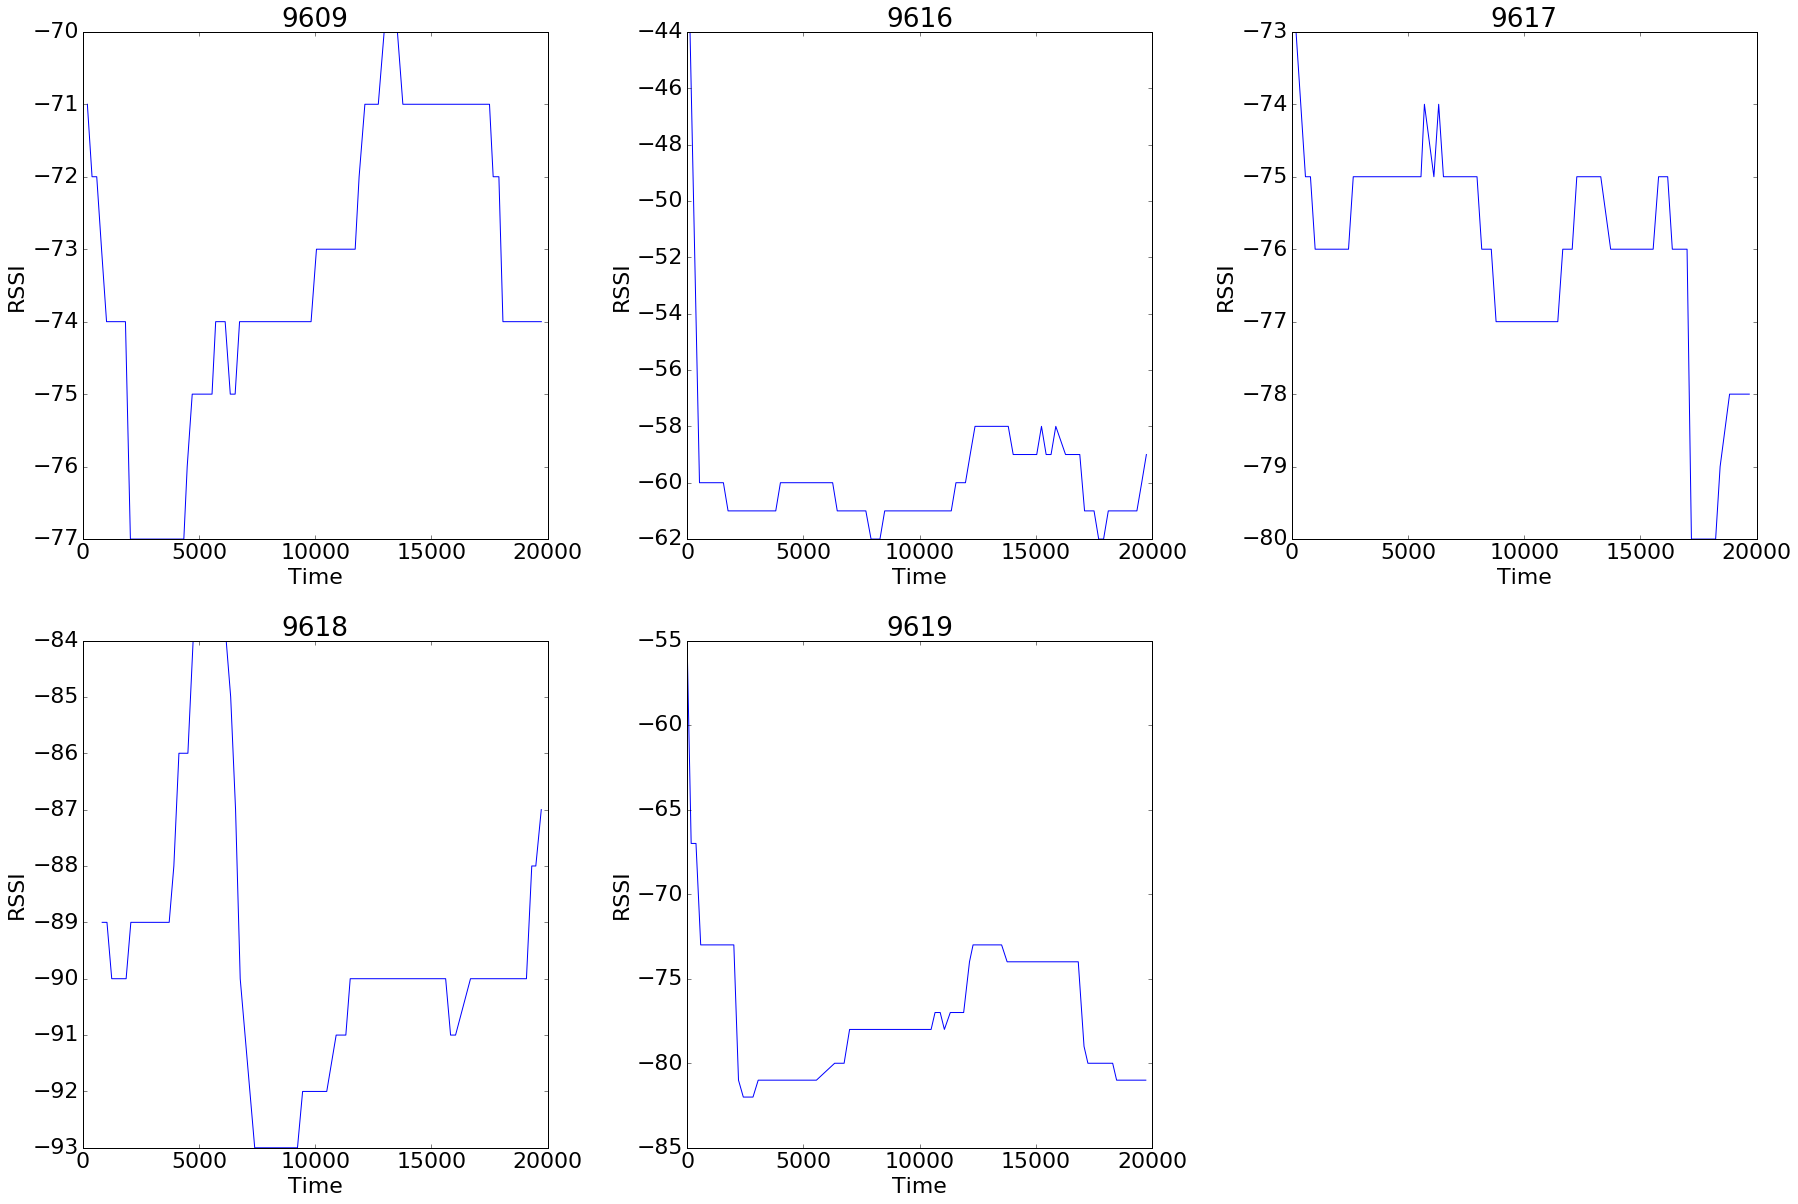

In [18]:
plot_rssi_data(standing_still, filter_func=create_rssi_median_filter(kernel=9))

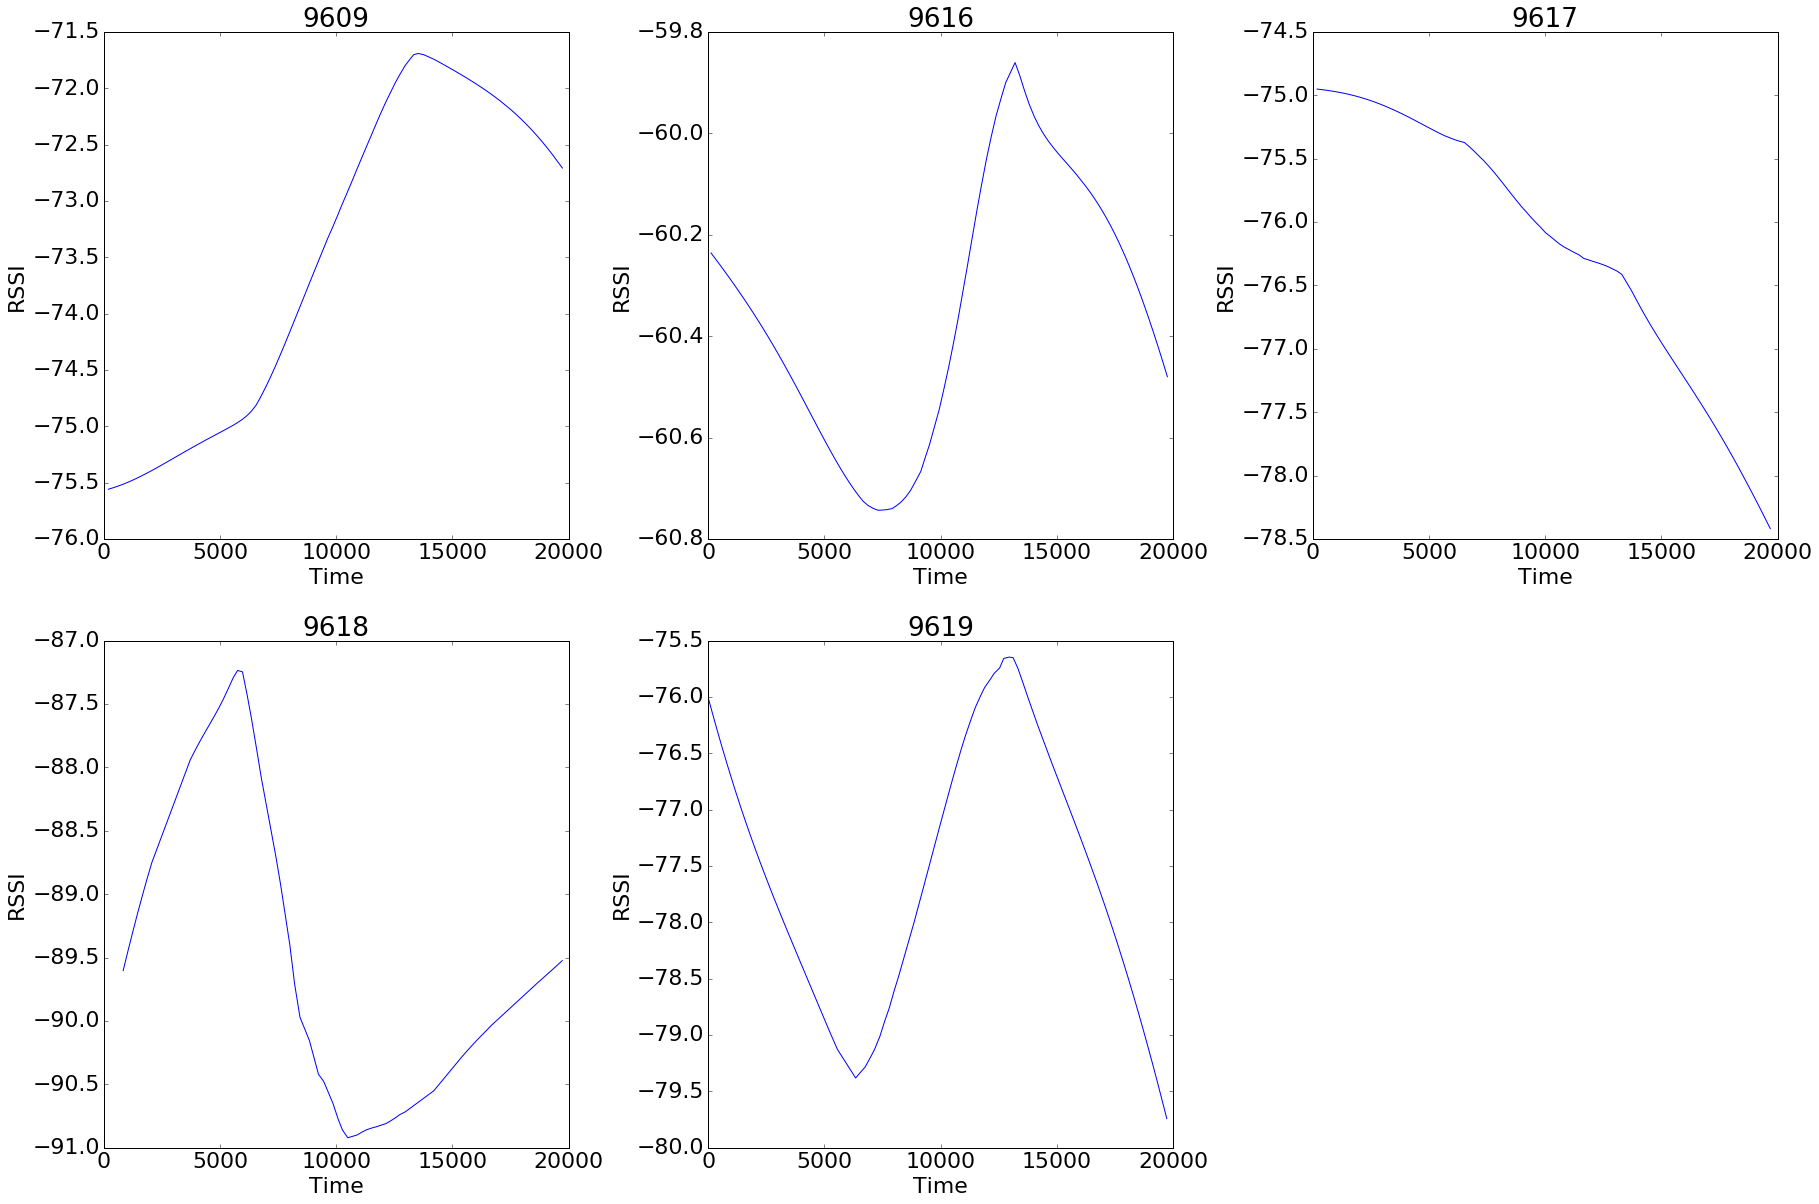

In [19]:
plot_rssi_data(standing_still, filter_func=rssi_lowess_filter)

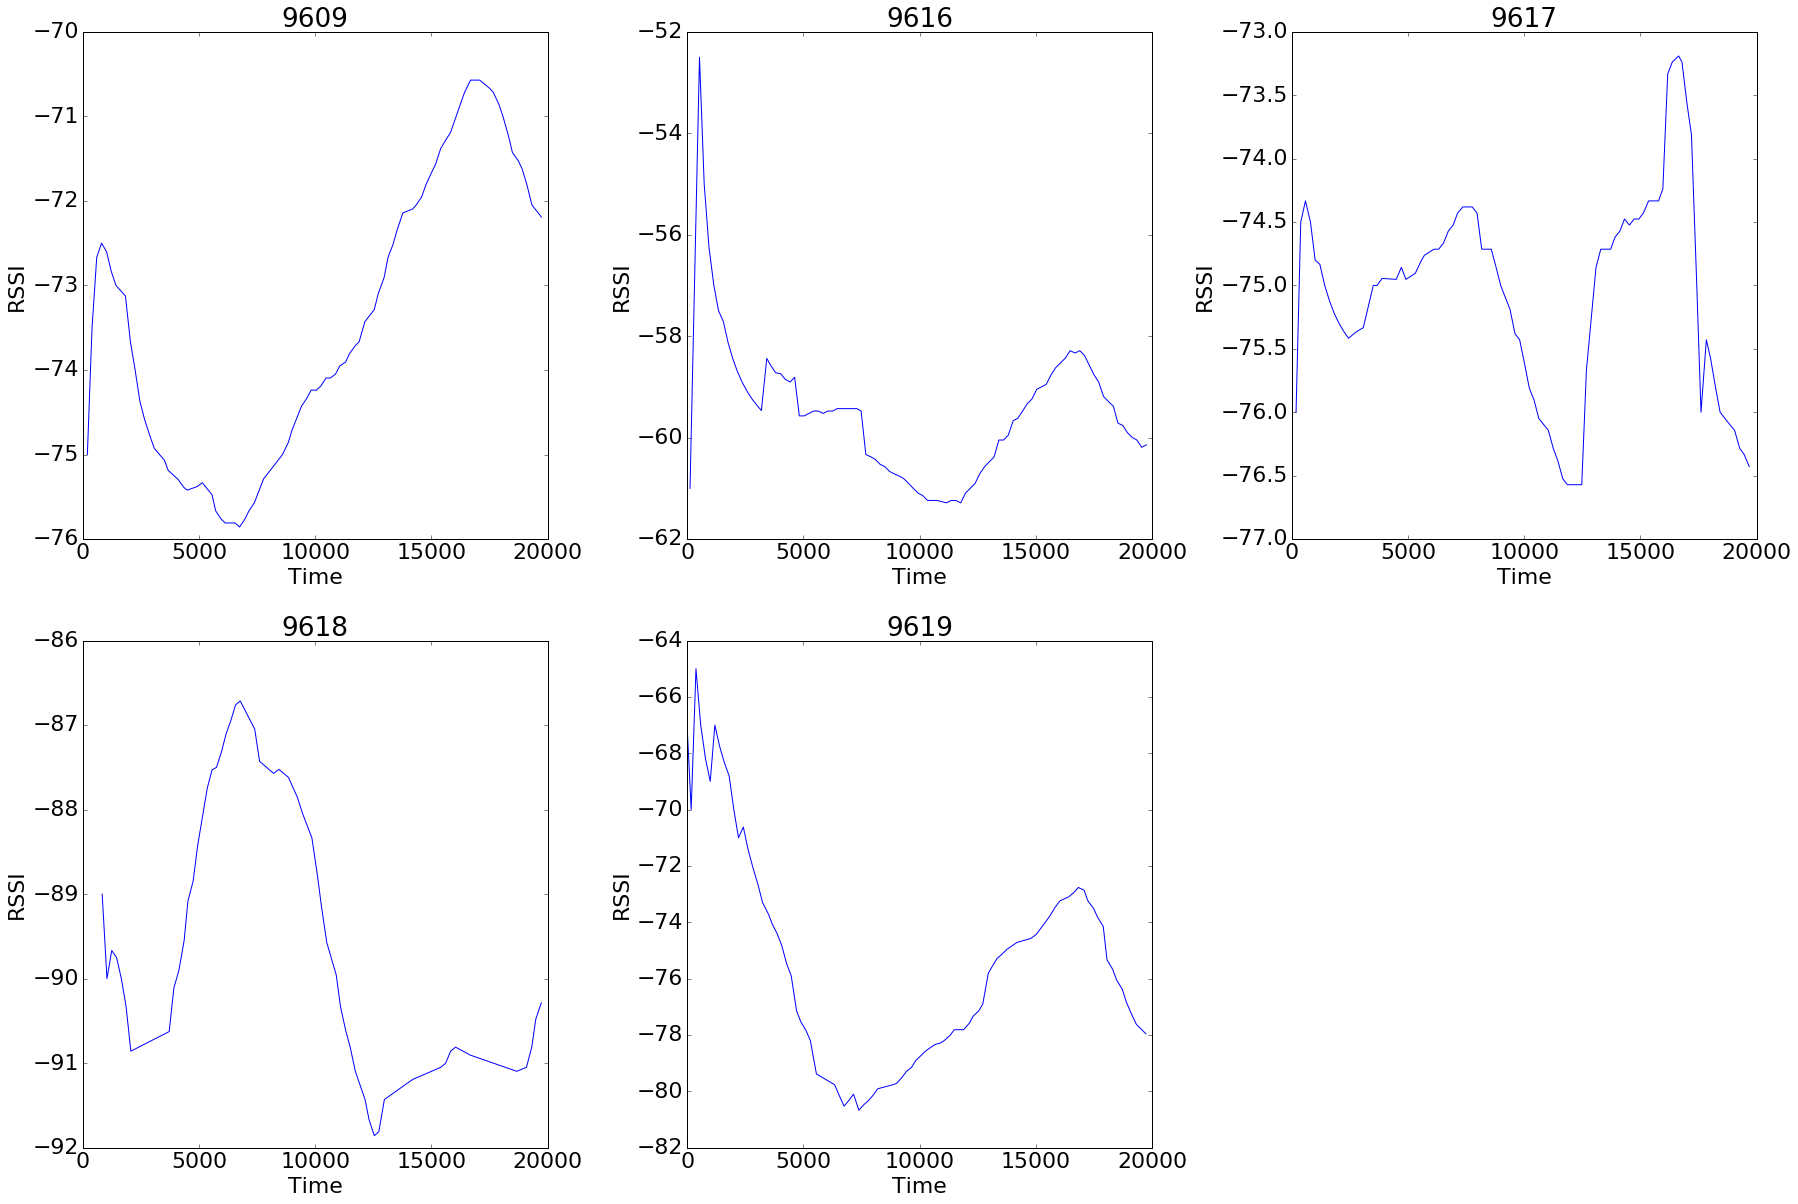

In [20]:
plot_rssi_data(standing_still, filter_func=create_rssi_avg_filter(kernel=21))

In [21]:
print_per_minor_stats(filter_session(standing_still, filter_func=create_rssi_median_filter(21)))
print_per_minor_stats(filter_session(straight_line, filter_func=create_rssi_median_filter(21)))

**Minor 9609
count    86.000000
mean    -73.011628
std       1.869219
min     -76.000000
25%     -74.000000
50%     -73.000000
75%     -71.000000
max     -71.000000
Name: RSSI, dtype: float64 


**Minor 9616
count    93.000000
mean    -60.075269
std       1.912411
min     -61.000000
25%     -61.000000
50%     -61.000000
75%     -60.000000
max     -44.000000
Name: RSSI, dtype: float64 


**Minor 9617
count    89.000000
mean    -75.820225
std       1.843673
min     -78.000000
25%     -77.000000
50%     -76.000000
75%     -75.000000
max     -62.000000
Name: RSSI, dtype: float64 


**Minor 9618
count    56.000000
mean    -88.589286
std       2.246426
min     -91.000000
25%     -91.000000
50%     -89.000000
75%     -86.000000
max     -86.000000
Name: RSSI, dtype: float64 


**Minor 9619
count    87.000000
mean    -76.689655
std       4.706034
min     -81.000000
25%     -80.000000
50%     -78.000000
75%     -74.000000
max     -55.000000
Name: RSSI, dtype: float64 


**Minor 9609
count    90.

In [22]:
print_per_minor_stats(filter_session(standing_still, filter_func=create_rssi_avg_filter(21)))
print_per_minor_stats(filter_session(straight_line, filter_func=create_rssi_avg_filter(21)))

**Minor 9609
count    86.000000
mean    -73.438642
std       1.692113
min     -75.857143
25%     -75.000000
50%     -73.690476
75%     -71.976190
max     -70.571429
Name: RSSI, dtype: float64 


**Minor 9616
count    93.000000
mean    -59.485369
std       1.356692
min     -61.285714
25%     -60.428571
50%     -59.476190
75%     -58.850000
max     -52.500000
Name: RSSI, dtype: float64 


**Minor 9617
count    89.000000
mean    -75.071981
std       0.811216
min     -76.571429
25%     -75.619048
50%     -74.950000
75%     -74.523810
max     -73.190476
Name: RSSI, dtype: float64 


**Minor 9618
count    56.000000
mean    -89.442671
std       1.566313
min     -91.857143
25%     -90.821429
50%     -89.825000
75%     -87.830357
max     -86.714286
Name: RSSI, dtype: float64 


**Minor 9619
count    87.000000
mean    -75.353782
std       3.801590
min     -80.666667
25%     -78.238095
50%     -75.666667
75%     -73.266106
max     -65.000000
Name: RSSI, dtype: float64 


**Minor 9609
count    90.

In [23]:
print_per_minor_stats(filter_session(standing_still, filter_func=rssi_lowess_filter))
print_per_minor_stats(filter_session(straight_line, filter_func=rssi_lowess_filter))

**Minor 9609
count    86.000000
mean    -73.477862
std       1.429587
min     -75.557937
25%     -75.026684
50%     -73.085081
75%     -72.117583
max     -71.692418
Name: RSSI, dtype: float64 


**Minor 9616
count    93.000000
mean    -60.360282
std       0.261369
min     -60.743150
25%     -60.589292
50%     -60.367726
75%     -60.148117
max     -59.860716
Name: RSSI, dtype: float64 


**Minor 9617
count    89.000000
mean    -76.178799
std       1.017042
min     -78.417596
25%     -76.932550
50%     -76.084685
75%     -75.248680
max     -74.951553
Name: RSSI, dtype: float64 


**Minor 9618
count    56.000000
mean    -89.364830
std       1.276913
min     -90.920775
25%     -90.574642
50%     -89.597399
75%     -87.924346
max     -87.236001
Name: RSSI, dtype: float64 


**Minor 9619
count    87.000000
mean    -77.555233
std       1.153526
min     -79.741385
25%     -78.555495
50%     -77.564835
75%     -76.604449
max     -75.646777
Name: RSSI, dtype: float64 


**Minor 9609
count    90.

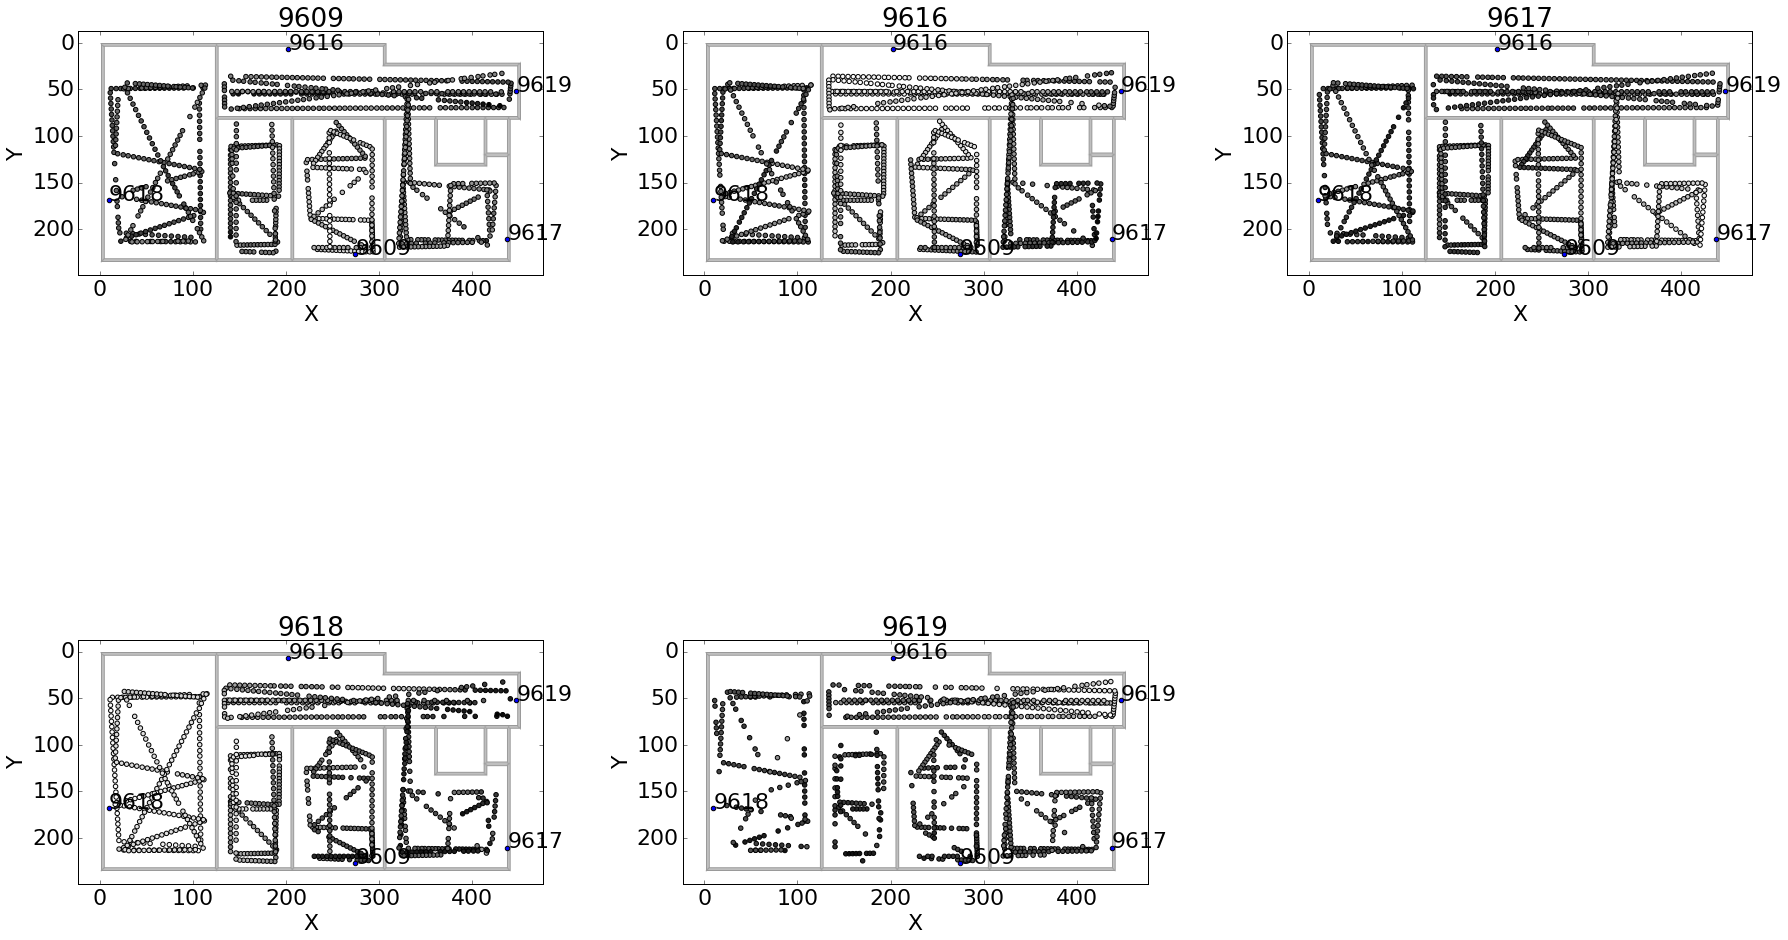

In [25]:
plot_rssi_map(filter_rssi_df(df, filter_func=create_rssi_avg_filter(21)), img, beacons=beacons)